In [151]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Excel dosyasını yükle
file_path = 'elektrik_veri_hashed.xlsx'
xls = pd.ExcelFile(file_path)
# Sayfa isimlerini görüntüle
print("Sayfa isimleri:", xls.sheet_names)
# Her sayfayı ayrı DataFrame'e yükle
df_tahsilat = pd.read_excel(xls, sheet_name='Tahsilat')
df_tahsilat_1 = pd.read_excel(xls, sheet_name='Tahsilat 1')
df_tahakkuk = pd.read_excel(xls, sheet_name='Tahakkuk') # Hamamözü
df_tahakkuk_1 = pd.read_excel(xls, sheet_name='Tahakkuk 1') # Gümüşhacıköy
df_tahakkuk_2 = pd.read_excel(xls, sheet_name='Tahakkuk 2') # Göynücek

Sayfa isimleri: ['Tahsilat', 'Tahsilat 1', 'Tahakkuk', 'Tahakkuk 1', 'Tahakkuk 2']


Her DataFrame için head(), info(), describe() ve tail() metodalrını çalıştıracak bir for döngüsü yazdım bu şekilde veriyi inceleme firsatı bulabiliriz.

In [81]:
# Diğer sayfalar için de ön inceleme yapmalısın
dataframes = [df_tahsilat, df_tahsilat_1, df_tahakkuk, df_tahakkuk_1, df_tahakkuk_2]
names = ["Tahsilat","Tahsilat 1", "Hamamözü (Tahakkuk)", "Gümüşhacıköy (Tahakkuk 1)", "Göynücek (Tahakkuk 2)"]

for df, name in zip(dataframes, names):
    print(f"--- {name} İncelemesi ---")
    df.head()
    df.info()
    print(df.describe())
    df.tail()
    print("-" * 30)

--- Tahsilat İncelemesi ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636993 entries, 0 to 636992
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Şube                   636993 non-null  object        
 1   Kasa                   636993 non-null  object        
 2   İlçe                   636993 non-null  object        
 3   Söz.hsp.(bağımsız)     636993 non-null  int64         
 4   Tahsilat Tarihi        636993 non-null  datetime64[ns]
 5   Nakit Tahsilat         523 non-null     float64       
 6   Mahsuben Tahsilat      7542 non-null    float64       
 7   Kredi Kartı Tahsilatı  0 non-null       float64       
 8   Banka Tahsilatı        628933 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 43.7+ MB
       Söz.hsp.(bağımsız)                Tahsilat Tarihi  Nakit Tahsilat  \
count        6.369930e+05                   

Her tahakkuk DataFrame'i için benzersiz kullanıcı sayısını hesapladım ve bunu figure olarak da görebilmek için görselleştirme yaptım. 

In [47]:
essiz_müsteri = len(pd.unique(df_tahakkuk['sozlesme_hesap_no']))
print(f" {df_tahakkuk.ilce[0]}'nde {essiz_müsteri} tane eşsiz müşteri var.")

 HAMAMÖZÜ'nde 2981 tane eşsiz müşteri var.


In [49]:
essiz_müsteri_1 = len(pd.unique(df_tahakkuk_1['sozlesme_hesap_no']))
print(f"{df_tahakkuk_1.ilce[0]}' de {essiz_müsteri_1} tane eşsiz müşteri var.")

GÜMÜŞHACIKÖY' de 18190 tane eşsiz müşteri var.


In [39]:
essiz_müsteri_2 = len(pd.unique(df_tahakkuk_2['sozlesme_hesap_no']))
print(f"{df_tahakkuk_2.ilce[0]}'nde {essiz_müsteri_2} tane eşsiz müşteri var.")

GÖYNÜCEK'nde 7128 tane eşsiz müşteri var.


In [57]:
ilceler = [df_tahakkuk.ilce[0], df_tahakkuk_1.ilce[0], df_tahakkuk_2.ilce[0]]
essiz_veriler = [essiz_müsteri, essiz_müsteri_1, essiz_müsteri_2]

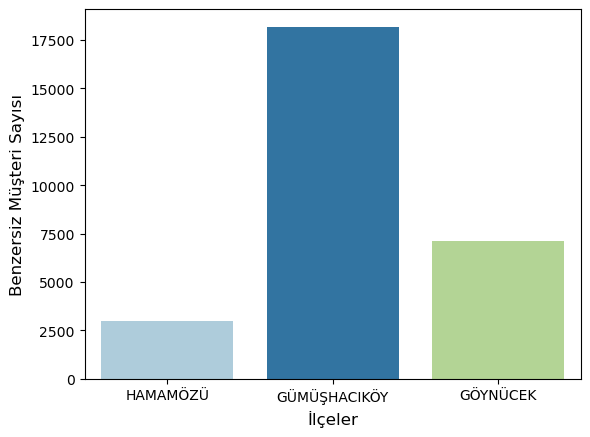

In [67]:
plt.figure()
sns.barplot(x= ilceler, y = essiz_veriler, palette="Paired")

plt.xlabel('İlçeler', fontsize=12)
plt.ylabel('Benzersiz Müşteri Sayısı', fontsize=12)
plt.show()

Tahakkuk dataframelerini concat() metodunu kullanarak birleştirdim. 

In [69]:
df_tum_tahakkuk = pd.concat([df_tahakkuk, df_tahakkuk_1, df_tahakkuk_2], ignore_index=True)
print(f"Toplam Tüketim Kaydı Sayısı: {len(df_tum_tahakkuk)}")

Toplam Tüketim Kaydı Sayısı: 1185698


kwh sütunundaki eksik, negatif veya aşırı uç değerlerin tespiti

In [77]:
# 1. Eksik Değerler
print("Eksik kWh Sayısı:", df_tum_tahakkuk['kwh'].isnull().sum())

Eksik kWh Sayısı: 0


In [75]:
#Negatif Tüketim 
negatif_tuketim = df_tum_tahakkuk[df_tum_tahakkuk['kwh'] < 0]
print(f"Negatif Tüketim Kaydı Sayısı: {len(negatif_tuketim)}")

Negatif Tüketim Kaydı Sayısı: 151


In [153]:
def anomaliTespiti(df,ozellik):
    outlier_indices = []
    
    for c in ozellik:
        # 1. çeyrek
        Q1 = np.percentile(df[c],25)
        # 3. çeyrek
        Q3 = np.percentile(df[c],75)
        # IQR: Çeyrekler açıklığı
        IQR = Q3 - Q1
        # aykırı tespiti için çarpan
        outlier_step = IQR * 1.5
        # aykırıyı ve aykırı indeksini tespit et
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # indeksleri depola
        outlier_indices.extend(outlier_list_col)
    
    # eşsiz aykırı değerleri bul
    outlier_indices = Counter(outlier_indices)
    # eğer bir örnek (v) 1 farklı sütun için aykırı değerse bunu aykırı olarak kabul et (v>1)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1)
    
    return multiple_outliers

In [155]:
veri_anamoli = df_tum_tahakkuk.loc[anomaliTespiti(df_tum_tahakkuk,["kwh"])]

In [157]:
veri_anamoli

,il,ilce,sozlesme_hesap_no,mali_yil_donem,fatura_tarihi,kayit_tarihi,vade_tarihi,hesap_sinifi,Hesap Sınıfı,kwh


df_tum_tahakkuk,["kwh"] için uç değerler bulunamadı. 

In [73]:
df_tum_tahakkuk['kwh'].describe()

count    1.185698e+06
mean     9.264207e+01
std      9.504052e+02
min     -2.537064e+04
25%      1.801000e+01
50%      4.662000e+01
75%      8.000000e+01
max      1.535757e+05
Name: kwh, dtype: float64

Hesap Sınıfıyla ilgili ortalama, medyan ve standart sapma tüketimlerini hesaplayıp tabloya ve grafiğe dönüştürdüm.

In [79]:
# Hesap sınıfına göre gruplayıp ortalama, medyan ve std sapma hesapla
ozet_tablo = df_tum_tahakkuk.groupby('hesap_sinifi')['kwh'].agg(['mean', 'median', 'std', 'count'])

# Okunabilir olması için sıralayalım (Kayıt sayısına göre)
ozet_tablo.sort_values(by='count', ascending=False, inplace=True)
ozet_tablo

,mean,median,std,count
hesap_sinifi,,,,
M001,55.590010,47.360,73.902931,1026609
T001,167.827953,41.600,781.762054,91298
TA01,541.608449,16.150,3627.959619,17266
M002,81.283512,56.140,111.164648,10173
T019,688.441598,23.860,3911.912974,8500
T002,136.952881,28.420,798.495578,6706
T021,29.965663,15.760,41.331395,3505
A001,32.435252,13.940,112.225490,3189
SE01,87.035189,76.540,56.599681,2671


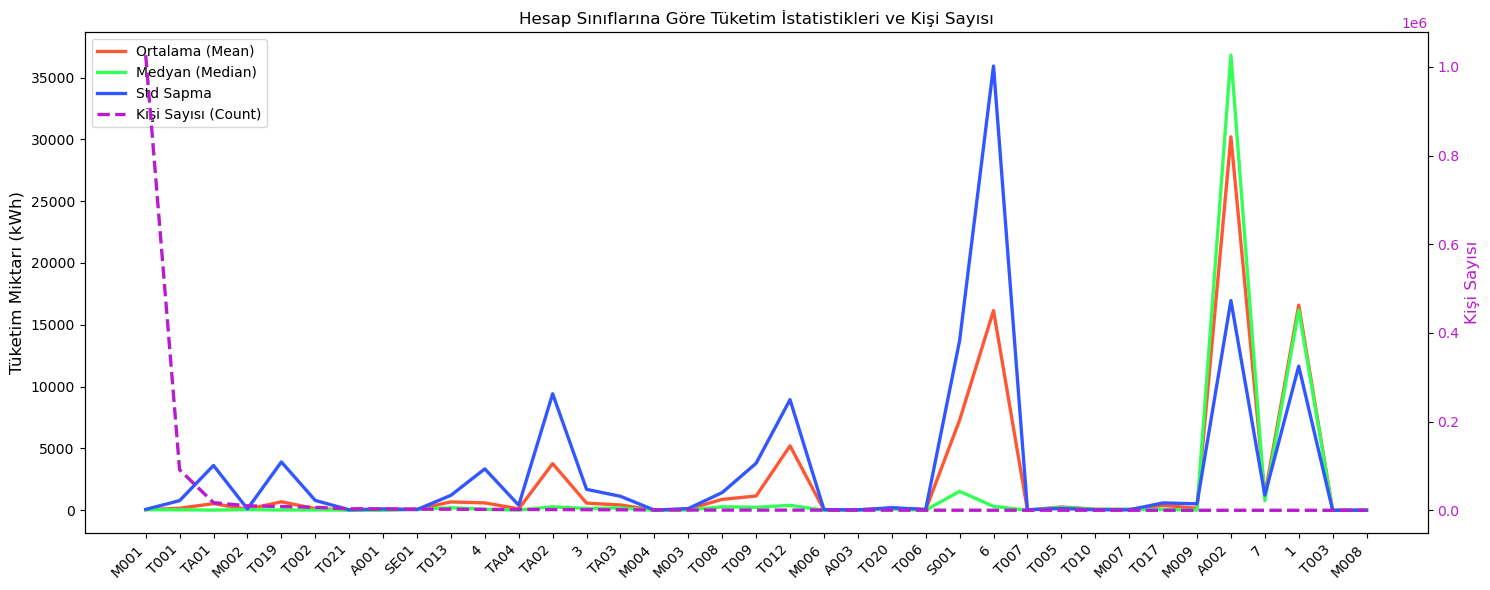

In [143]:
import matplotlib.pyplot as plt

# X eksenini string formatına çevirme (Hata almamak için)
x_ekseni = ozet_tablo.index.astype(str)

# Figür oluşturma
fig, ax1 = plt.subplots(figsize=(15, 6))

# --- SOL EKSEN (Tüketim Değerleri: Mean, Median, Std) ---
# Her biri için farklı renkler tanımlıyoruz
ax1.plot(x_ekseni, ozet_tablo['mean'],   color="#FF5733", linewidth=2.4, label='Ortalama (Mean)') # Turuncu
ax1.plot(x_ekseni, ozet_tablo['median'], color="#33FF57", linewidth=2.4, label='Medyan (Median)')  # Yeşil
ax1.plot(x_ekseni, ozet_tablo['std'],    color="#3357FF", linewidth=2.4, label='Std Sapma')        # Mavi

# Sol eksen ayarları
ax1.set_ylabel('Tüketim Miktarı (kWh)', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_xticklabels(x_ekseni, rotation=45, ha='right') # Yazıların birbirine girmemesi için

# --- SAĞ EKSEN (Müşteri Sayısı: Count) ---
ax2 = ax1.twinx() # İkinci bir Y ekseni yaratıyoruz
# Count verisini farklı bir renk ve stil (kesikli çizgi) ile çiziyoruz ki karışmasın
ax2.plot(x_ekseni, ozet_tablo['count'],  color="#B81DCD", linewidth=2.4, linestyle='--', label='Kişi Sayısı (Count)') # Mor
ax2.set_ylabel('Kişi Sayısı', color="#B81DCD", fontsize=12)
ax2.tick_params(axis='y', labelcolor="#B81DCD")

# --- LEJANT (Hangi renk ne demek?) ---
# İki eksendeki etiketleri tek bir kutuda toplamak için:
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title("Hesap Sınıflarına Göre Tüketim İstatistikleri ve Kişi Sayısı")
plt.tight_layout()
plt.show()